# Natural Language Processing - Generation in Victor Hugo's style

### Gallier Hugues, Legris Tristan

This notebook is dedicated to the study of author discrimination and text generation.

The task we want to achieve can be classified in the category of sequence classification tasks. However, we think that this task is particularly interesting in the sense that it requires advanced insights on the interpretation of the models to understand how it works. We would like ideally to capture stylistic caracteristics of the texts.

We have collected several works of different known authors of the french litterature as you can see on the author_book dictionnary which follows. These authors are mainly of the 19th century as we think that it is important to have comparable books in term of language and literary genre. Indeed we have focused on novels only, rather than other genres like essays or poetry, because we are more used to reading novels. Morevoer, it is less specific than the latters, so more interesting for our study. We will not provide an advanced litterary explenation for our results but one may think that studying famous authors guarantees that these ones have a proper style. 

These books are free of rights and were collected in the html format, and preprocessed to turn them in text sequences. We suppressed tables of contents and notes at the beginnig and end of the books, but some edition details may have passed through our filter. However, we think that these details are sufficiently scarce to be ignored, as they won't probably be of any help in the vast majority of time.

This project is separated in two main parts : 
- The first one contains the discrimination part.
- The second one contains the work on the generation part.











# Import of all necessary files

In [ ]:
!ls

author_model_1	author_model_2	sample_data


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-QQT9QS6piE4Y25Tml91ulR7HHACRKn2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-QQT9QS6piE4Y25Tml91ulR7HHACRKn2" -O camembert_ziped && rm -rf /tmp/cookies.txt

In [ ]:
!unzip camembert_ziped

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10I8tGf9lgfqO3YpkZx_87U7ClXrHwf7n' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=10I8tGf9lgfqO3YpkZx_87U7ClXrHwf7n" -O final_gpt_zied && rm -rf /tmp/cookies.txt

In [ ]:
!unzip final_gpt_zied

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1XcKsRon8nue3UErHuRn466ChgZSbrIVf' -O clean_texts_ziped

In [ ]:
!unzip clean_texts_ziped

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Gzl7dMjKi7Bi1nUm10Vt4JsLX-mT7MMd' -O df30

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1blJvZRPO4LHTveErA9NRrIcWm6kzhOID' -O df100

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1bf2kEqlFk_PA7yAS54Jsp5zDrVgefiiO' -O df300

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1yaVsaC4jRO2TjeJXeHSVukoijQbhy-LP' -O all_texts.txt

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1TqtPEfc8GCMNQ2l61_XNSBXQo7s3_Crn' -O hugo_concat.txt

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWIziIUoXu_2CdnuIR3__Ko2xD-hHr6G' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWIziIUoXu_2CdnuIR3__Ko2xD-hHr6G" -O author_model_1 && rm -rf /tmp/cookies.txt

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1--sV6f9NeUiedkWE_x2NK7Kycyadgxfk' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1--sV6f9NeUiedkWE_x2NK7Kycyadgxfk" -O author_model_2 && rm -rf /tmp/cookies.txt

In [ ]:
ls

all_texts.txt   camembert_ziped    df100  final_gpt_zied   models/
author_model_1  clean_texts/       df30   gpt_model/       sample_data/
author_model_2  clean_texts_ziped  df300  hugo_concat.txt


In [ ]:
!pip install transformers
!pip install nltk
!pip install datasets

     |████████████████████████████████| 2.1MB 11.1MB/s 
     |████████████████████████████████| 3.3MB 50.7MB/s 
     |████████████████████████████████| 901kB 59.8MB/s 
     |████████████████████████████████| 204kB 10.8MB/s 
     |████████████████████████████████| 112kB 31.8MB/s 
     |████████████████████████████████| 245kB 25.4MB/s 


In [ ]:
import pdb
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
import itertools
import torch.optim as optim
import re
from sklearn.metrics import roc_curve, auc
import random
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import seaborn as sn
from numpy import dot
from numpy.linalg import norm

# Part I: Discrimination

##Lecture

In [ ]:
author_books={
    'hugo':    ["bug_jargal", "dernier_jour", "notre_dame", "quatre_vingt_treize", 
                "miserables_1", "miserables_2", "miserables_3", "miserables_4", "miserables_5",
                "napoleon_petit"],
    'leblanc': ["les_milliards", "cagliostro", "victor_brigade", "barre_y_va", "femme_deux_sourires"],
    "gautier": ["mademoiselle_maupin"],
    "staël":  ["corinne_1", "corinne_2"],
    "conrad" : ["coeur_tenebres"],
    'balzac' : ['le_pere_goriot', 'l_heritiere_de_birague_2', 'annette_et_le_criminel_1'],
    'sand' : ['la_filleule', 'adriani', 'tamaris'],
    'chateaubriand' : ['memoires_outre_tombe1', 'memoires_outre_tombe2', 'aventures_dernier_abencerage'],
    'bernanos' : ['les_grands_cimetieres', 'un_crime', 'journal_d_un_cure_de_campagne'],
    'dumas' : ['le_pere_la_ruine_1', 'cecile', 'sylvandire'],
     'proust' : ['a_la_recherche_du_temps_perdu_1_swann', 'a_la_recherche_du_temps_perdu_2_ombre_filles',
                 'a_la_recherche_du_temps_perdu_3_cote_guermantes']
}

book_list= list(itertools.chain.from_iterable(author_books.values()))

In [ ]:
#commented books will serve for the test

author_train={
    'hugo':    [#"bug_jargal", "dernier_jour", "notre_dame", "quatre_vingt_treize", "napoleon_petit"
                "miserables_1", "miserables_2", "miserables_3", "miserables_4", "miserables_5"],
    'leblanc': ["les_milliards", "cagliostro", "victor_brigade"],  #  "barre_y_va", "femme_deux_sourires"],
    "gautier": ["mademoiselle_maupin"],
    "staël":  ["corinne_1"], #"corinne_2"

    "conrad" : ["coeur_tenebres"],

    'balzac' : ['le_pere_goriot', 'annette_et_le_criminel_1'], #'l_heritiere_de_birague_2',

    'sand' : ['la_filleule','tamaris'], #'adriani',

    'chateaubriand' : ['memoires_outre_tombe1', 'aventures_dernier_abencerage'],  #'memoires_outre_tombe2',

    'bernanos' : ['les_grands_cimetieres', 'journal_d_un_cure_de_campagne'],  #'un_crime',

    'dumas' : ['le_pere_la_ruine_1', 'sylvandire'],  #'cecile',

     'proust' : ['a_la_recherche_du_temps_perdu_1_swann', 'a_la_recherche_du_temps_perdu_3_cote_guermantes']  #'a_la_recherche_du_temps_perdu_2_ombre_filles',
}

train_books= list(itertools.chain.from_iterable(author_train.values()))
test_books= set(list(itertools.chain.from_iterable(author_books.values())))-set(train_books)
test_books

{'a_la_recherche_du_temps_perdu_2_ombre_filles',
 'adriani',
 'barre_y_va',
 'bug_jargal',
 'cecile',
 'corinne_2',
 'dernier_jour',
 'femme_deux_sourires',
 'l_heritiere_de_birague_2',
 'memoires_outre_tombe2',
 'napoleon_petit',
 'notre_dame',
 'quatre_vingt_treize',
 'un_crime'}

In [ ]:
#load the dataframes
import pickle

with open('df300', 'rb') as openfile:
  df_samples_300= pickle.load(openfile)
with open('df100', 'rb') as openfile:
  df_samples_100= pickle.load(openfile)
with open('df30', 'rb') as openfile:
  df_samples_30= pickle.load(openfile)

In [ ]:
with open(r'clean_texts/miserables_1.txt', 'r', encoding='utf8') as file:
  book= file.read()
book[:200]#incipit

'En 1815, M. Charles-François-Bienvenu Myriel était évêque de Digne. C’était un vieillard d’environ soixante-quinze ans ; il occupait le siège de Digne depuis 1806. \n Quoique ce détail ne touche en auc'

In [ ]:
with open(r'clean_texts/bug_jargal.txt', 'r', encoding='utf8') as file:
  book= file.read()
book[:200]#incipit

"Quand vint le tour du capitaine Léopold d'Auverney, il ouvrit de grands yeux et avoua à ces messieurs qu'il ne connaissait réellement aucun événement de sa vie qui méritât de fixer leur attention. \n –"

##Train Test split

In [ ]:
def shuffle_text(text):
  """Shuffle a given text to test the models"""
  text= np.array(text.split(' '))
  random.shuffle(text)
  text= ' '.join(text)
  return text

for size, df in zip([300,100, 30], [df_samples_300, df_samples_100, df_samples_30]):
  df['sample size']= size
  df['sample shuffle']= df.apply(lambda x: shuffle_text(x[2]), axis=1)

df_samples= df_samples_30.append(df_samples_100).append(df_samples_300)

df_samples.columns

Index(['author', 'book', 'sample', 'sample size', 'sample shuffle'], dtype='object')

In [ ]:
#train test split

df_train, df_test_same, df_test_other= tuple([pd.DataFrame(columns=df_samples.columns)]*3)
df_train_, df_test_same_, df_test_other_= tuple([pd.DataFrame(columns=df_samples.columns)]*3)
for size in [300, 100, 30]:
  df_train_= df_samples[(df_samples['book'].isin(train_books)) & (df_samples['sample size']== size)]
  df_test_other_= df_samples[(df_samples['book'].isin(test_books)) & (df_samples['sample size']== size)]

  df_train_, df_test_same_= train_test_split(df_train_, test_size= 0.3)
  df_train= df_train.append(df_train_)
  df_test_other= df_test_other.append(df_test_other_)
  df_test_same= df_test_same.append(df_test_same_)

  print(df_train_.shape, df_test_same_.shape,  df_test_other_.shape)


(4680, 5) (2007, 5) (3891, 5)
(12425, 5) (5325, 5) (10249, 5)
(30234, 5) (12958, 5) (24661, 5)


##Models on tokens only

In this part we use classical ML models, in out case SVM. Firstly we train a word2vec on our corpus and observe the results.
Then we average the embeddings of the words on the samples of texts. We obtained a vector per sample, of the same dimensions of the embeddings and train ACP and SVM on it. This method applies to texts considered as bag of words and do not take in account the relationship between them

##Embeddings

In [ ]:
#Loop on the books
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        for book_name in book_list:
          path= r'clean_texts/'+book_name+ '.txt'
          for line in open(path):
            # assume there's one document per line, tokens separated by whitespace
            yield self._preprocess(line)

    @staticmethod
    def _preprocess(txt):
        return [w for w in re.sub('(?<=[a-z|à|é|è|ê])\.', ' <EOS>', txt).replace('’', "'").replace(',', ' ,').replace("'", "' ").lower().split(' ')
                if len(w) > 0]

In [ ]:
"""def _preprocess(txt):
    return [w for w in re.sub('(?<=[a-z|à|é|è|ê])\.', ' <EOS>', txt).replace('’', "'").replace(',', ' ,').replace("'", "' ").lower().split(' ')
            if len(w) > 0]"""

'def _preprocess(txt):\n    return [w for w in re.sub(\'(?<=[a-z|à|é|è|ê])\\.\', \' <EOS>\', txt).replace(\'’\', "\'").replace(\',\', \' ,\').replace("\'", "\' ").lower().split(\' \')\n            if len(w) > 0]'

In [ ]:
#train the word2vec
sentences = MyCorpus()
model = Word2Vec(sentences=sentences, size=300, max_vocab_size=30000, window=20)

We obtain a satisfying word2vec as we can see that we obtrain relevant outputs for usual tests.

In [ ]:
model.wv.most_similar('roi')

[('ministre', 0.8546451330184937),
 ('parlement', 0.8165574073791504),
 ('procureur', 0.8118927478790283),
 ('président', 0.8079439997673035),
 ('général', 0.8075175285339355),
 ('louis', 0.8050813674926758),
 ('prince', 0.8047752380371094),
 ('duc', 0.799148678779602),
 ('cardinal', 0.7879475355148315),
 ('pape', 0.787004828453064)]

In [ ]:
model.wv.most_similar('rue')

[('maison', 0.8294453024864197),
 ('barrière', 0.8132064938545227),
 ('cour', 0.8006076812744141),
 ('montmartre', 0.7947956323623657),
 ('salle', 0.7839478850364685),
 ('porte', 0.7682929039001465),
 ('boulevard', 0.7527079582214355),
 ('saint-denis', 0.751110315322876),
 ('ville', 0.7477044463157654),
 ('étage', 0.7442418932914734)]

In [ ]:
model.wv.most_similar('père')

[('grand-père', 0.8412768840789795),
 ('mari', 0.8363202810287476),
 ('frère', 0.8278619050979614),
 ('oncle', 0.8043713569641113),
 ('cousin', 0.7907978296279907),
 ('fils', 0.7704820036888123),
 ('neveu', 0.749275803565979),
 ('ami', 0.7326560020446777),
 ('camarade', 0.7072281837463379),
 ('grand-oncle', 0.6800083518028259)]

In [ ]:
model.wv.similar_by_vector(model.wv['père'] - model.wv['homme'] + model.wv['femme'] )

[('sœur', 0.6860984563827515),
 ('père', 0.673914909362793),
 ('mère', 0.6556546688079834),
 ('mari', 0.6547549962997437),
 ('amie', 0.5884970426559448),
 ('tante', 0.5767383575439453),
 ('baronne', 0.5644265413284302),
 ('veuve', 0.5510659217834473),
 ('morte', 0.54573655128479),
 ('cousine', 0.5423297882080078)]

In [ ]:
model.wv.similar_by_vector(model.wv['roi'] - model.wv['homme'] + model.wv['femme'] )

[('reine', 0.7038581967353821),
 ('veuve', 0.6406586766242981),
 ('paroisse', 0.568687379360199),
 ('viii', 0.5617150068283081),
 ('dame', 0.5610083937644958),
 ('sœur', 0.5580902099609375),
 ('roi', 0.5576299428939819),
 ('disait-on', 0.5515812039375305),
 ('demoiselle', 0.5483378767967224),
 ('duc', 0.5410747528076172)]

##ACP

We make an ACP on the obtained vectors. We limit it to the samples of length 30. In fact we have noticed that the size of the text did not impact the result of the ACP. This phenomenon can be interpreted as we show below.

In [ ]:
def samples2vectors(samples, trained_word2vec, dim=300):
  """Turn samples in average embedding"""
  new_sample = list()
  for sample in samples:
    tweetVecs = list()
    for token in MyCorpus._preprocess(sample):
      try: tweetVecs.append(trained_word2vec.get_vector(token)  )
      except: tweetVecs.append( np.zeros(dim) ) 
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)

In [ ]:
#we make a pca only on a defined length for interpretability

df_pca= df_samples[df_samples['sample size']==30]
X = samples2vectors(df_pca.loc[:, "sample"], model.wv)

<BarContainer object of 20 artists>

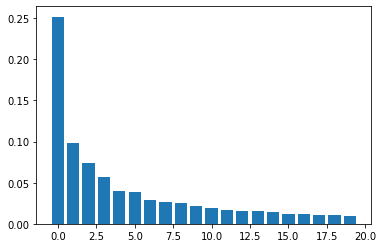

In [ ]:
from sklearn.decomposition import PCA
pca= PCA()
pca.fit(X)
plt.bar(np.arange(20), pca.explained_variance_ratio_[:20])

The PCA shows a strong concentration on the first component. We try to interpret those components by seeking the closest words for each components.

For each component we can see 2 columns on the following dataframe, one for the closest words of the vector component and another for the colsest words of the opposit of the same vector.

We can make some observations and give a plausible interpration for several one.

1.  the 1st components seems to represent the presence of dialogues. In one sense we ca see imperative verds, wheareas in the other they are more descriptive.

2.  The 2nd component is much difficult to interpret, but we can see that numerous characters have escaped the POS tagging filter and  that they are represented in this component.

3.  In the 3rd we can see an opposition between action/army related words and words related to interiority.

4.  In the 4th we can see numerous verbs conjugated at the past simple and imperfect.

5.  In the 5th we can sharply distinguish face descriptive words opposed to words related in some way to power. 

In [ ]:
df_components= pd.DataFrame()
for i in range(0,5):
  for coef in [1,-1]:
    df_components[str(i+1)+'e composante ('+str(coef)+')']= list(list(zip(*model.wv.most_similar(positive=[pca.components_[i]*coef], topn=40)))[0])

We observe the projection of the texts on the main components.

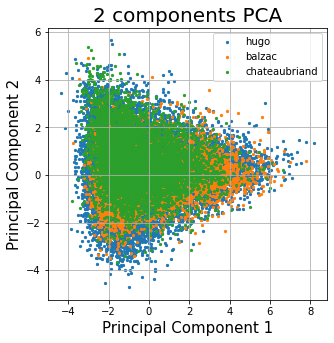

In [ ]:
X_pca= pca.transform(X)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 components PCA', fontsize = 20)
targets= ['hugo', 'balzac', 'chateaubriand']
for target in targets:
    indicesToKeep = df_pca['author'] == target
    ax.scatter(X_pca[indicesToKeep, 0]
               , X_pca[indicesToKeep, 1]
               , s = 5, alpha=1)
ax.legend(targets)
ax.grid()

In [ ]:
import plotly.express as px
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

indicesToKeep = df_pca['author'].isin(targets)

fig = px.scatter_matrix(
    X_pca[indicesToKeep, :],
    labels=labels,
    dimensions=range(4),
    opacity= 0.5,
    color=df[indicesToKeep]['author']
)
fig.update_traces(diagonal_visible=False, marker= dict(size=2))
fig.show()

As we can observe the few authors taken recover each other, even if we can can see different concentrations for each of them. We can notice that Victor Hugo is very well spread compared for example to Dumas. 

Thus we cannot separate the authors according to these features. This is in fact very logic. These features are macroscopical feature and do not reprensent the style of the author but rather the repartition of the texts on sort of subject or type of narration.

##SVM model

In [ ]:
def roc(labels, scores, legend=''):
  fpr_rf, tpr_rf, _ = roc_curve(labels, scores)
  axes= plt.gca()
  auc_val= auc(fpr_rf, tpr_rf)
  #plt.figure(1)
  axes.plot([0, 1], [0, 1])
  axes.plot(fpr_rf, tpr_rf, label = legend+' AUC: %0.2f' % auc_val)
  axes.set_xlabel('False positive rate')
  axes.set_ylabel('True positive rate')
  axes.set_title('ROC curve')
  axes.legend(loc='best')
  #plt.show()

def conf_matrix(y_test, y_pred):
  print(classification_report(y_test, y_pred) )
  cm = confusion_matrix(y_test, y_pred) 
  labels = ['other', 'hugo']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()


In [ ]:
X_train, y_train = samples2vectors(df_train.loc[:, "sample"], model.wv),\
 (df_train['author']=='hugo').to_numpy().astype(int)
X_test_same, y_test_same = samples2vectors(df_test_same.loc[:, "sample"], model.wv),\
 (df_test_same['author']=='hugo').to_numpy().astype(int)
X_test_other, y_test_other = samples2vectors(df_test_other.loc[:, "sample"], model.wv),\
 (df_test_other['author']=='hugo').to_numpy().astype(int)
X_train.shape, X_test_same.shape, X_test_other.shape

((47339, 300), (20290, 300), (38801, 300))

In [ ]:
#repartition of Visor Hugo in the samples
np.mean(y_train), np.mean(y_test_same), np.mean(y_test_other)

(0.26821436870233845, 0.26476096599310006, 0.37145949846653437)

We train the SVM on samples of size 30. We will observe the results on longer samples later. 

In [ ]:
svc = LinearSVC(verbose=1, random_state=42)

train_size= 30
indices_train= (df_train['sample size']==train_size)
svc.fit(X_train[indices_train,:], y_train[indices_train])

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=1)

In [ ]:
y_pred_same = svc.predict(X_test_same)
y_pred_other = svc.predict(X_test_other)
y_score_same = svc.decision_function(X_test_same)
y_score_other = svc.decision_function(X_test_other)

The roc curve shows that the SVM obtain very proper scores and that longer samples give better results. Thus longer texts give refined embedded vectors, which we can think are less variable.

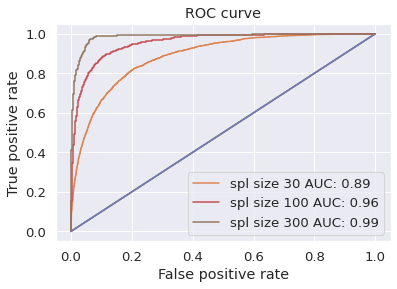

In [ ]:
for i, test_size in zip([1,2,3], [30,100, 300]):
  indices= (df_test_same['sample size']== test_size)
  roc(y_test_same[indices], y_score_same[indices], 'spl size '+str(test_size))

We can see a significant drop in the perforances when we test on other novels than those used for training, but they keep good.

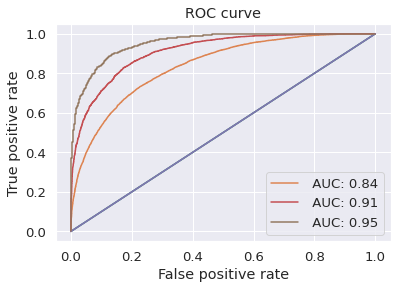

In [ ]:
for i, test_size in zip([1,2,3], [30,100, 300]):
  indices= (df_test_other['sample size']== test_size)
  roc(y_test_other[indices], y_score_other[indices])

We would like to see if the seperator plan can be interpreted along the ACP components. 
We calculate below the projection (cosine similarity) of the guiding vector of the SVM on the ACP components.

We have seen that we could interpret the first components of the ACP but that it became more difficult beyond the very first ones. So we probabbly can't interpret those ones. In particular, we can wonder if the seperator is sensible to some specific words. We tried to fool the SVM with some words whose embedding are close to vectors whose coordinates are made to fool the decision function, but the observation was that it did not have any noticeable impact.

But we see that the main projections are quite far from the first components. As we have said previously, the separation is not made upon the first components, but rather on tiny differences, difficult to explain.

<BarContainer object of 300 artists>

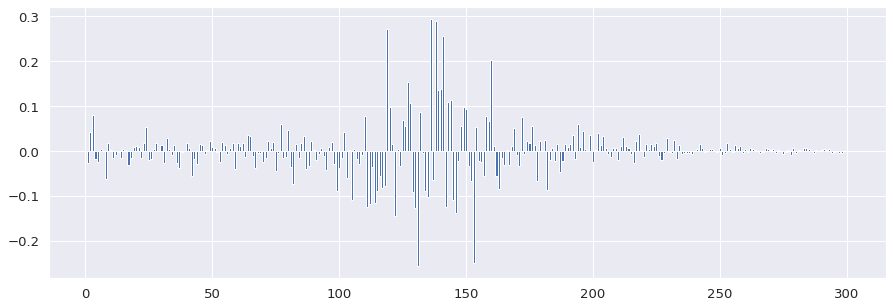

In [ ]:
#projection sur les axes de l'acp

cosine_sim=[]
for i in range(pca.components_.shape[0]):
  cosine_sim.append(dot(pca.components_[i], svc.coef_[0]-pca.mean_)/(norm(svc.coef_[0]-pca.mean_)*norm(pca.components_[i])))

plt.figure(figsize = (15,5))
plt.bar(np.arange(1,301), cosine_sim)

In [ ]:
v= np.random.random(300)*2-np.ones(300)
norm_coef= norm(svc.coef_)
proj= (v @ svc.coef_.T)[0]/norm_coef
v= v - 100*svc.intercept_[0]/norm_coef * svc.coef_[0]/norm_coef 
if proj<0:
  v= v - 2*proj* svc.coef_[0]/norm_coef 

#we verify that this embeddings is in the right class
print('decision function score: ' + str(svc.decision_function([v])[0]))

#we look at the closest words
print('Closest words score:\n')
list(zip(svc.decision_function(samples2vectors(list(zip(*model.wv.most_similar(positive=[v])))[0], model.wv)), 
         list(zip(*model.wv.most_similar(positive=[v])))[0]))

decision function score: 34.93076217959859
Closest words score:



[(-0.8128902599462294, 'insomnie'),
 (-0.5156781858525236, 'oxygène'),
 (2.5364949230342773, 'nuit'),
 (-1.63329620143642, 'bouger'),
 (-3.611570514493206, 'aben-hamet'),
 (0.3579863258320245, 'yeux'),
 (-2.0965022401294617, 'ardeur'),
 (-2.2989744885629717, 'toucher'),
 (1.7571042385721496, 'nuits'),
 (-0.7831997989173427, 'désespérés')]

###We limit ourselves to the main axis of the ACP

We would like to see the relevent dimension to separate the authors, reducing the space to the main axis of the ACP.

We make an observation on a space reduced to 100 compoents

In [ ]:
X_train_pca= pca.transform(X_train)
X_test_same_pca= pca.transform(X_test_same)
X_test_other_pca= pca.transform(X_test_other)
#X_train.shape, X_test_same.shape, X_test_other.shape

In [ ]:
n_comp= 100
train_size= 30
indices_train= (df_train['sample size']==train_size)

svc = LinearSVC(verbose=1, random_state=42)
svc.fit(X_train_pca[indices_train,:n_comp], y_train[indices_train])

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=1)

In [ ]:
y_pred_same = svc.predict(X_test_same_pca[:,:n_comp])
y_pred_other = svc.predict(X_test_other_pca[:,:n_comp])
y_score_same = svc.decision_function(X_test_same_pca[:,:n_comp])
y_score_other = svc.decision_function(X_test_other_pca[:,:n_comp])

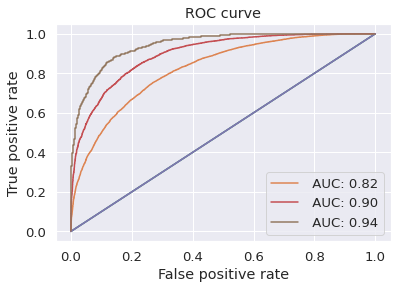

In [ ]:
for i, test_size in zip([1,2,3], [30,100, 300]):
  indices= (df_test_other['sample size']== test_size)
  roc(y_test_other[indices], y_score_other[indices])

The auc scores of the model keeps quite high here.
We see on the following figure that the weights have (obviously) shifted on the reduced spaced axis, and they seem a bit more spread than previously, but the very first ones keep low.

<BarContainer object of 100 artists>

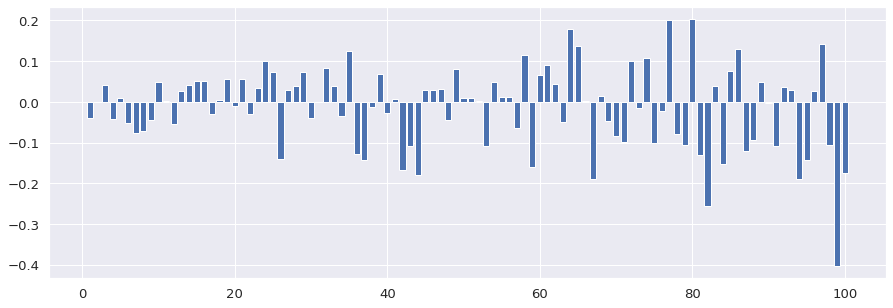

In [ ]:
plt.figure(figsize = (15,5))
plt.bar(np.arange(1,n_comp+1), svc.coef_[0][:n_comp]/norm(svc.coef_[0]))

In order to verify that the first components can't be sufficient to discriminate authors, we draw in the subsequent cells the auc scores of models for different space sizes. We see that the performance decrease below 100 dimensions.*texte en italique*

In [ ]:
train_size= 30
indices_train= (df_train['sample size']==train_size)
auc_scores=[]

for n_comp in np.arange(300, 0, -20):
  print(n_comp)
  svc = LinearSVC(verbose=1, random_state=42)
  svc.fit(X_train_pca[indices_train,:n_comp], y_train[indices_train])
  y_score_other = svc.decision_function(X_test_other_pca[:,:n_comp])

  for test_size in [30,100,300]:
    indices_test= (df_test_other['sample size']== test_size)
    fpr_rf, tpr_rf, _ = roc_curve(y_test_other[indices_test], y_score_other[indices_test])
    auc_scores.append( auc(fpr_rf, tpr_rf) )

auc_scores= np.array(auc_scores).reshape((-1,3))

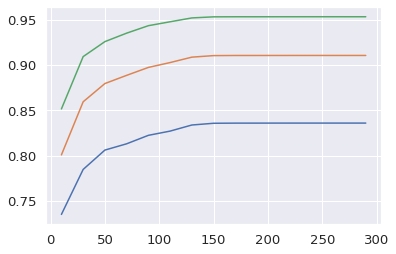

In [ ]:
plt.plot(np.arange(10, 310, 20), auc_scores[::-1,0])
plt.plot(np.arange(10, 310, 20), auc_scores[::-1,1])
plt.plot(np.arange(10, 310, 20), auc_scores[::-1,2])

We would like to see to what extent the model is robust to fake text. As it is constructed in a bag of word modelization, we know that it can't seize the 'style' of an author. So a shuffled text will have the same score as the original one. However, we can generate fake text, based on real word frequency. Discarding random text is indeed a minimum requirement.

We calculate below the word frequency on the corpus.

In [ ]:
from collections import Counter
from functools import reduce
from operator import add

arr = df_samples[df_samples['sample size']==300]['sample'].drop_duplicates().apply(lambda x: MyCorpus._preprocess(x)).array
arr = reduce(add, arr[random.sample(range(len(arr)), 2000)])
# We use reduce to concatenate all the lists in arr, but we don't use "set" 
# so that we can count occurencies with a Counter object 
c = Counter(arr)
print(c)
# Formating the counter object to a proper dataset
d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d.columns=['word', 'occurences']
# Computing frequencies instead of occurences
nb_total = d.occurences.sum()
d['freq'] = d.occurences.apply(lambda x: x/nb_total)
# Sorting by frequency, most frequent word at the top of the df
d = d.sort_values('freq', ascending=False).reset_index(drop=True)

assert d.loc[2, 'word']== '<eos>'

d.loc[2, 'word']='.'

In [ ]:
def random_text_generator(n=1, l=1, d=d):
  texts=[]
  for i in range(n):
    texts.append(' '.join(np.random.choice(d['word'], l, p=d['freq'])))
  return np.array(texts)#.reshape((n,1))

## Modèle camembert

We try now a deep learning model.

This model is based on tha camemBERT architecture. We expect it to capture more stylistic features than the SVM because the samples are not treated in a bag of words manner. The model can perceive the relationship between words.

### Config

In [ ]:
def get_sample(df_samples, index=0, author= None, book=None):
  """get a sample from an author"""
  if (author is not None) & (book is not None):
    return df_samples[(df_samples['author']==author) & (df_samples['book']==book)].\
    reset_index(drop=True).iloc[index]
  elif author is not None:
    return df_samples[df_samples['author']==author].reset_index(drop= True).iloc[index]
  elif book is not None:
    return df_samples[df_samples['book']==book].reset_index(drop=True).iloc[index]
  else:
    return df_samples.iloc[index]

def preprocess_bert(paragraph, tokenizer, maxlen):
  """tokenize and add appropriate tokens for bert"""
  tokens = tokenizer.tokenize(paragraph) #Tokenize the sentence
  bos_token = tokenizer.bos_token
  eos_token = tokenizer.eos_token
  
  tokens = [bos_token] + tokens + [eos_token] #Insering the CLS and SEP token in the beginning and end of the sentence
  if len(tokens) < maxlen:
      tokens = tokens + [tokenizer.pad_token for _ in range(maxlen - len(tokens))] #Padding sentences
  else:
      tokens = tokens[:maxlen-1] + [eos_token] #Prunning the list to be of specified max length

  tokens_ids = tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
  tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
  #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
  attn_mask = (tokens_ids_tensor != 1).long()
  return tokens_ids_tensor, attn_mask

In [ ]:
#the dataset class

class TextSamples(Dataset):
  
    def __init__(self, df_samples, sample_type='sample', negative_samples='random', p= 0, #author_books= author_books,
                 len_random= 30, pos_author='hugo', model_name='camembert-base',
                 maxlen= 300):
      
        self.df_samples=df_samples

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.maxlen=  maxlen
        self.pos_author= pos_author
        self.p= p
        self.sample_type= sample_type
        self.negative_samples= negative_samples
        self.len_random= len_random

    def __len__(self):
        return len(self.df_samples)

    def __getitem__(self, index):
        """We can add negative random samples with p parametor"""
        if random.random()<self.p:
          if self.negative_samples== 'shuffle':
            sample = self.df_samples.iloc[index]['sample shuffle']
            label = 0
          elif self.negative_samples== 'random':
            sample= random_text_generator(l= self.len_random, d= d)[0]
            label= 0
        else:
          sample = self.df_samples.iloc[index]['sample']
          label = 1 if self.df_samples.iloc[index]['author'] == self.pos_author else 0

        #print(self.df_samples.iloc[index]['author'])
        tokens_ids_tensor, attn_mask = preprocess_bert(sample, self.tokenizer, self.maxlen)

        return tokens_ids_tensor, attn_mask, label

In [ ]:
def detokenized_text(tokenized_sequence, special_char="▁",
                     special_token=['</s>', '<s>', '<pad>']):
  detokenized_text = ""
  for ind, token in enumerate(tokenized_sequence):
    if token in special_token: continue
    if token.startswith(special_char):
      detokenized_text+=" "+token[1:]
    else:
      detokenized_text+=token
    
  return detokenized_text

The classifier is made of a linear layer on top of a core camembert model.

In [ ]:
#the classifier class

class AuthorClassifier(nn.Module):

    def __init__(self, pretrained_model_name='camembert-base'):
        super(AuthorClassifier, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, 1)
        #ajouter un logit
        self.sigmoid= nn.Sigmoid()

    def proba(self, seq, attention_mask):
        logits = self.__call__(seq, attention_mask)
        proba= self.sigmoid(logits)
        return proba

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..
        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head
        pool = cont_reps["pooler_output"]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(pool)

        return logits

In [ ]:
def train(model, criterion, opti, train_loader, max_eps=1,
          gpu=False, print_every=100,):
    if gpu:
      model = model.to("cuda")
    for ep in range(max_eps):
        
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            #print(it)
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits = model(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels.float())

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()
            if it % print_every == 0:
                accuracy = torch.sum((logits>0).int().squeeze(1)==labels)/float(labels.size(0))
                recall= torch.sum(((logits>0).int().squeeze(1)==labels) & (labels==1) )/torch.sum(labels==1)
                print("[{}/{}][{}/{}], n_pos: {}, Loss : {}, Accuracy {}, Recall {} ".format(ep+1, max_eps, it, len(train_loader),
                                                                       torch.sum(labels==1).item(), loss.item(),accuracy, recall))


Like for the SVM, the evaluation is performed on the test dataset composed of texts either from the same books or other books than those used for training.

In [ ]:
def print_scores(model, sample):
  seq, attn_mask= preprocess_bert(sample, tokenizer, 300)
  seq, attn_mask= seq.to('cuda'), attn_mask.to('cuda')
  return model.proba(seq.unsqueeze(0), attn_mask.unsqueeze(0)).item()

def eval_model(model, df, sample_type='sample', negative_samples='random', p= 0, #author_books= author_books,
                 len_random= 30, print_every=None, pos_author= 'hugo'):
  labels, scores= [], []

  for i in range(df.shape[0]):

    if random.random()< p:
      if negative_samples== 'shuffle':
        sample = df_samples.iloc[index]['sample shuffle']
        label = 0
      elif negative_samples== 'random':
        sample= random_text_generator(l= len_random, d= d)[0]
        label= 0

      author= 'no author'
      book= negative_samples+ ' text'
    else:
      sample= df.iloc[i][sample_type]
      author= df.iloc[i]['author']
      book= df.iloc[i]['book']
      label = 1 if df.iloc[i]['author'] == pos_author else 0

    seq, attn_mask= preprocess_bert(sample, tokenizer, 300)
    seq, attn_mask= seq.to('cuda'), attn_mask.to('cuda')
    score= author_model.proba(seq.unsqueeze(0), attn_mask.unsqueeze(0)).item()
    labels.append(label)
    scores.append(score)

    if (print_every is not None) and (i % print_every == 0):
      print('{},  {}'.format(author, book))
      print(sample)
      print('\n')
      print(score)
      print('\n-------------------')
  return labels, scores

###Model 1

We train a first model, as in the previous cases, on the train novels defined at the beginning.

Only one epoch seems to be sufficient for training, as the loss does not diminish at the end of it.

In [ ]:
# pos_author= 'hugo'
# train_size= 30
# train_dataset= TextSamples(df_train[df_train['sample size']==train_size], pos_author= pos_author, p=0)
# train_loader = DataLoader(train_dataset, batch_size = 20, num_workers = 5)

In [ ]:
# author_model = AuthorClassifier('camembert-base')
# author_model = author_model.to("cuda")

# criterion = nn.BCEWithLogitsLoss()
# opti = optim.Adam(author_model.parameters(), lr = 1e-5)
# author_model.train()
# train(author_model, criterion, opti, train_loader, max_eps=1, print_every=20, gpu=True)
# torch.save(author_model.state_dict(), "/content/drive/My Drive/NLP/author_model_1")

In [ ]:
author_model = AuthorClassifier("camembert-base").to("cuda")
author_model.load_state_dict(torch.load("author_model_1"))
author_model.eval()
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

We print some samples and their proba score between the evaluation process.

In [ ]:
test_size= 30
labels_30_1, scores_30_1= eval_model(author_model.eval(), df_test_other[df_test_other['sample size']==test_size], 'sample', print_every= 1000)

print_every= 10**6
test_size= 100
labels_100_1, scores_100_1= eval_model(author_model.eval(), df_test_other[df_test_other['sample size']==test_size], 'sample', print_every= print_every)
test_size= 300
labels_300_1, scores_300_1= eval_model(author_model.eval(), df_test_other[df_test_other['sample size']==test_size], 'sample', print_every= print_every)

*Note: the model has some trouble on Bug Jargal, which is quite normal, since  it is the first novel of Victor Hugo (written at 16 years old)

We can observe that the model has better performances than the SVM on the books not used for training, which is rather satisfying.

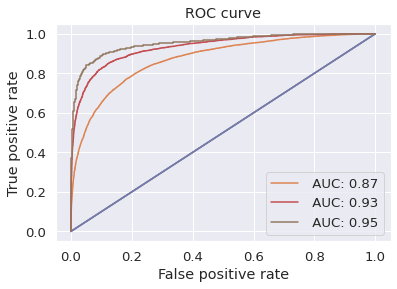

In [ ]:
roc(labels_30_1, scores_30_1)
roc(labels_100_1, scores_100_1)
roc(labels_300_1, scores_300_1)

Now we test our model on random text. We see that we obtain a very bad result. The model seems to be completely fooled by a text which has no sense.

We verify it on a test dataset composed at 50% of random text and other 50% of Victor Hugo. The result is worse than for SVM. 

It means that the model does not make good relations between the words, thought we were expecting it

In [ ]:
print_scores(random_text_generator(l=100)[0])

0.004539151210337877

In [ ]:
test_size= 30
labels_30, scores_30= eval_model(author_model.eval(), df_test_other[(df_test_other['sample size']==test_size) & (df_test_other['author']==pos_author)], 'sample', print_every= 100, p=0.5)

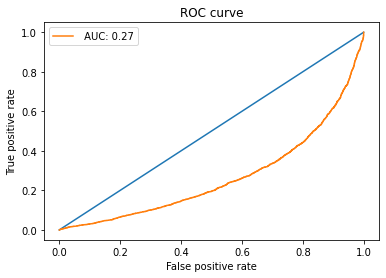

In [ ]:
roc(labels_30, scores_30)

###Modèle 2

To correct the model we add negative samples composed of random text in de trainning data, up to 20%

In [ ]:
# pos_author= 'hugo'
# train_size= 30
# train_dataset= TextSamples(df_train[df_train['sample size']==train_size], pos_author= pos_author, p=0.2)
# train_loader = DataLoader(train_dataset, batch_size = 20, num_workers = 5)
# author_model = AuthorClassifier('camembert-base')
# author_model = author_model.to("cuda")
# criterion = nn.BCEWithLogitsLoss()
# opti = optim.Adam(author_model.parameters(), lr = 1e-5)

In [ ]:
# author_model.train()
# train(author_model, criterion, opti, train_loader, max_eps=1, print_every=20, gpu=True)
# torch.save(author_model.state_dict(), "/content/drive/My Drive/NLP/author_model_2")

In [ ]:
author_model = AuthorClassifier("camembert-base").to("cuda")
author_model.load_state_dict(torch.load("author_model_2"))
author_model.eval()
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

In [ ]:
test_size= 30
labels_30_2, scores_30_2= eval_model(author_model.eval(), df_test_other[df_test_other['sample size']==test_size], 'sample', print_every=100)
print_every= 10**6
test_size= 100
labels_100_2, scores_100_2= eval_model(author_model.eval(), df_test_other[df_test_other['sample size']==test_size], 'sample', print_every=print_every)
test_size= 300
labels_300_2, scores_300_2= eval_model(author_model.eval(), df_test_other[df_test_other['sample size']==test_size], 'sample', print_every=print_every)

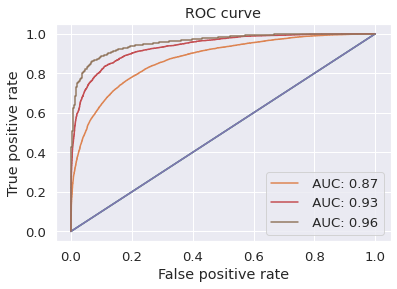

In [ ]:
roc(labels_30_2, scores_30_2)
roc(labels_100_2, scores_100_2)
roc(labels_300_2, scores_300_2)

In [ ]:
test_size= 30
print_every= 10**6
labels_30_2_rd, scores_30_2_rd= eval_model(author_model.eval(), df_test_other[(df_test_other['sample size']==test_size) & (df_test_other['author']==pos_author)], 'sample', print_every= print_every, p=0.5)

hugo,  bug_jargal
Quand vint le tour du capitaine <mask> d'Auverney, il ouvrit de grands yeux et avoua à ces messieurs qu'il ne connaissait réellement aucun événement de sa vie qui méritât de


0.015698647126555443

-------------------


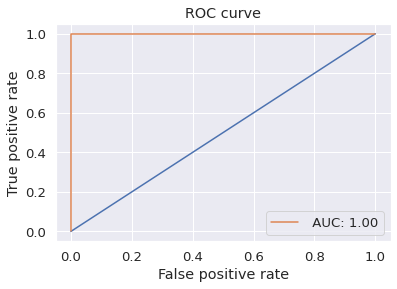

In [ ]:
roc(labels_30_2_rd, scores_30_2_rd)

We can see that on shuffle text, the model recognizes that it cannot be some text from Victor Hugo

In [ ]:
print(print_scores(author_model, 'Une cagoule noire lui tombait jusqu’aux pieds, un caffardum de même couleur lui cachait le visage. On ne voyait rien de sa personne, ni sa face ni ses mains. C’était un long suaire noir qui se tenait debout, et sous lequel on sentait remuer quelque chose. Elle regarda fixement quelques minutes cette espèce de spectre. Cependant, elle ni lui ne parlaient. On eût dit <mask> statues qui se confrontaient. <mask> choses seulement semblaient vivre dans le caveau ; la mèche de la lanterne qui pétillait à cause de <mask>humidité de <mask>atmosphère, et la goutte d’eau de la voûte qui coupait'))
print_scores(author_model, shuffle_text('Une cagoule noire lui tombait jusqu’aux pieds, un caffardum de même couleur lui cachait le visage. On ne voyait rien de sa personne, ni sa face ni ses mains. C’était un long suaire noir qui se tenait debout, et sous lequel on sentait remuer quelque chose. Elle regarda fixement quelques minutes cette espèce de spectre. Cependant, elle ni lui ne parlaient. On eût dit <mask> statues qui se confrontaient. <mask> choses seulement semblaient vivre dans le caveau ; la mèche de la lanterne qui pétillait à cause de <mask>humidité de <mask>atmosphère, et la goutte d’eau de la voûte qui coupait'))

0.8258981704711914


0.004688477609306574

# Part 2 Generation

In [ ]:
from gensim.models import Word2Vec
import re
import tensorflow as tf
import numpy as np

## I : From Scratch

In this part, we try to create a model from scratch to generate some text. We are aware that for this type of problem, transfer learning is the best way to go. Nonetheless, we thought that it would be interesting to have a baseline model in order to see the gain using much deeper and much larger models.


The approach we use is:
- 1) To train our own word embeddings on all the texts we have (all authors, 20 Mo).
- 2) To use these embedding as embedding matrix (not trainable) and stack an RNN on it

The model is trained to predict the next word given a sequence. The loss used is the cross entropy.

*Note: it was easier to do it with tensorflow and Keras, but this is the only part using TF, the rest is in Pytorch*

### 1) Train Word2vec

Why training our own embeddings ?
- Because there are very few pre-trained embedding in French on the web
- Because these pre-trained embeddings are trained on texts very different then ours (like wikipedia, Twitter ...) and it is very likely that some words take a different meaning in our dataset.
- Because it is fun to train :)

Here we load the data

In [ ]:
def preprocess(txt):
        return re.sub('(?<=[a-z|à|é|è|ê])\.', ' <EOS>', txt).replace('’', "'").replace(',', ' ,').replace("'", "' ").lower()
                      
with open("all_texts.txt", "r") as f:
    all_concat = preprocess(f.read())

with open("hugo_concat.txt", "r") as f:
    hugo_concat = preprocess(f.read())

We train the word2vec model using the Gensim library

In [ ]:
model = Word2Vec(sentences=[t.split() for t in all_concat.split('\n')], size=300, max_vocab_size=30000, window=10)

### 2) Preprocess data

In this subpart, we will:
- First, create the tokenizer, the embedding matrix and the associated look-up table. For this, we simply use individual words, and the vectors obtained above by our word2vec model
- Second, transform Victor Hugo's texts given the created tools

In [ ]:
index2word = {i + 1: w for i, w in enumerate(model.wv.index2word)}
index2word[0] = '<unk>'
tokenizer = {w: i for i, w in index2word.items()}

Simple test to assert if it works well

In [ ]:
index2word[tokenizer['bonjour']]

'bonjour'

In [ ]:
embedding_matrix = np.empty((len(index2word), 300))
for i in range(1, len(index2word)):
    embedding_matrix[i] = model.wv.get_vector(index2word[i])

# Here, we set unknown word's embedding to the mean of all vectors
embedding_matrix[0, :] = np.mean(embedding_matrix[1:], axis=0)

Now we transform Victor Hugo's texts

In [ ]:
hugo_tokenized = [tokenizer.get(word, 0) for word in hugo_concat.split()]

In [ ]:
' '.join([index2word[idx] for idx in hugo_tokenized][:50])

"quand vint le tour du capitaine léopold d' auverney , il ouvrit de grands yeux et avoua à ces messieurs qu' il ne connaissait réellement aucun événement de sa vie qui <unk> de fixer leur attention <eos> – mais , capitaine , lui dit le lieutenant henri , vous avez"

In [ ]:
len(hugo_tokenized)

1502635

### 3) Fit model

Our model is the following:
- (non trainable) Embedding matrix of size (len(vocabulary), 300); we don't train it to be faster, and empirically this did not give worse results.
- 3 GRU layers with 128 units on each layer
- a dense layer of size 200
- a dense layer of size len(vocabulary) with a softmax activation

In [ ]:
seq_len = 30

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(hugo_tokenized)
sequences = ids_dataset.batch(seq_len + 1, drop_remainder=True)

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(2):
    print("Input :", [index2word[i] for i in input_example.numpy()])
    print("Target:", [index2word[i] for i in target_example.numpy()])

Input : ['quand', 'vint', 'le', 'tour', 'du', 'capitaine', 'léopold', "d'", 'auverney', ',', 'il', 'ouvrit', 'de', 'grands', 'yeux', 'et', 'avoua', 'à', 'ces', 'messieurs', "qu'", 'il', 'ne', 'connaissait', 'réellement', 'aucun', 'événement', 'de', 'sa', 'vie']
Target: ['vint', 'le', 'tour', 'du', 'capitaine', 'léopold', "d'", 'auverney', ',', 'il', 'ouvrit', 'de', 'grands', 'yeux', 'et', 'avoua', 'à', 'ces', 'messieurs', "qu'", 'il', 'ne', 'connaissait', 'réellement', 'aucun', 'événement', 'de', 'sa', 'vie', 'qui']
Input : ['<unk>', 'de', 'fixer', 'leur', 'attention', '<eos>', '–', 'mais', ',', 'capitaine', ',', 'lui', 'dit', 'le', 'lieutenant', 'henri', ',', 'vous', 'avez', 'pourtant', ',', 'dit-on', ',', 'voyagé', 'et', 'vu', 'le', 'monde', '<eos>', "n'"]
Target: ['de', 'fixer', 'leur', 'attention', '<eos>', '–', 'mais', ',', 'capitaine', ',', 'lui', 'dit', 'le', 'lieutenant', 'henri', ',', 'vous', 'avez', 'pourtant', ',', 'dit-on', ',', 'voyagé', 'et', 'vu', 'le', 'monde', '<eos>',

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = (dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, rnn_units=128, vocab_size=len(index2word), embedding_dim=300):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                               weights=[embedding_matrix])
    self.embedding.trainable = False
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True)
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True)
    self.gru3 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True)
    
    self.gru = [self.gru1, self.gru2, self.gru3]
    self.dense1 = tf.keras.layers.Dense(200, activation='relu')
    self.dense2 = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, state1=None, state2=None, state3=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if state1 is None:
        state1 = self.gru1.get_initial_state(x)
    x, states1 = self.gru1(x, initial_state=state1, training=training)
    if state2 is None:
        state2 = self.gru2.get_initial_state(x)
    x, states3 = self.gru2(x, initial_state=state2, training=training)
    if state3 is None:
        state3 = self.gru3.get_initial_state(x)
    x, states3 = self.gru3(x, initial_state=state3, training=training)
    x = self.dense1(x, training=training)
    x = self.dense2(x, training=training)

    if return_state:
      return x, state1, state2, state3
    else:
      return x

rnn = MyModel()

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = rnn(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 30, 14250) # (batch_size, sequence_length, vocab_size)


In [ ]:
# loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
# rnn.compile(optimizer='adam', loss=loss)
# rnn.summary()
# history = rnn.fit(dataset, epochs=100)
# rnn.save_weights('rnn')

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  4275000   
_________________________________________________________________
gru_3 (GRU)                  multiple                  165120    
_________________________________________________________________
gru_4 (GRU)                  multiple                  99072     
_________________________________________________________________
gru_5 (GRU)                  multiple                  99072     
_________________________________________________________________
dense_2 (Dense)              multiple                  25800     
_________________________________________________________________
dense_3 (Dense)              multiple                  2864250   
Total params: 7,528,314
Trainable params: 3,253,314
Non-trainable params: 4,275,000
______________________________________

In [ ]:
class OneStep:
    def __init__(self, model=rnn, index2word=index2word, tokenizer=tokenizer, temperature=1/2):
        self.temperature = temperature
        self.model = model
        self.index2word = index2word
        self.tokenizer = tokenizer

        sparse_mask = tf.SparseTensor(
            values=[-float('inf')],
            indices=[[0]],  # we prevent model to generate <unk> for now
            dense_shape=[len(tokenizer)])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @staticmethod
    def _preprocess(text):
        _preprocessed = re.sub('(?<=[a-z|à|é|è|ê])\.', ' <EOS>', text).replace('’', "'").replace(',', ' ,').replace("'", "' ").lower()
        return [[tokenizer.get(word, 0) for word in _preprocessed[:100].split()]]

    def generate_one_step(self, inputs, states=[None, None, None]):
        # Convert strings to token IDs
        input_ids = tf.convert_to_tensor(self._preprocess(inputs))

        # Run the model.
        predicted_proba, *states = self.model(inputs=input_ids, state1=states[0],
                                               state2=states[1], state3=states[2],
                                               return_state=True)
        # Only use the last prediction.
        predicted_proba = predicted_proba[:, -1, :]
        predicted_proba = predicted_proba / self.temperature + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_proba, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)
        # predicted_ids = tf.argmax(predicted_proba, axis=-1)

        # Convert from token ids to characters
        predicted_words = [self.index2word[idx] for idx in predicted_ids.numpy()]

        # Return the characters and model state.
        return predicted_words, states

As we can see in the following, our model predicts only some isolated words without creating much sense.

It could surely be improved with Beam Search or more sophisticated methods, but we decided to focus on other models that could give better results in the following parts, with BERT and GPT.

In [ ]:
one_step_model = OneStep(rnn, temperature=1)

states = [None, None, None]
text = "Le vieux chien s'en alla"
for n in range(100):
  next_word, states = one_step_model.generate_one_step(text, states=states)
  text += ' ' + next_word[0]
text

"Le vieux chien s'en alla là <eos> mess lethierry s' était assis sous sa robe <eos> la façade les uns évidemment le , du l' la plus était comme , de le apparut , de était , était était sur <eos> par ou de ou ne , le dans pour <eos> <eos> et l' les le le et tout , , depuis de au et aux , avait , de de apparut était et le : , , prend de par était d' avait sur tout , , ne autour était et <eos> par <eos> fit par à comme à . au , , par"

### Conclusion of part I

Even if Word2Vec gave some surprisingly good results given the relatively small amount of text we had, we haven't manage to obtain a model that seems usable in practice.

We decided not to give too much time on this approach that was designed to be a baseline, and started using BERT.

## II: Using BERT as embedding

In this part, we use a quite similar approach to the preceding part. Namely, we will use CamemBERT as an embedding layer, and stack an rnn on it.

The task will again be to predict the next word given the sequence at hand, with a cross entropy loss function.

### 1) Preparing data

Here we load the tokenizer from CamemBERT base (using Huggingface library).

Then, we will preprocess the data of hugo_concat accordingly, and create a dataset that will be used to train the model

In [ ]:
import pdb
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader

MODEL_NAME = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

We will now tokenize our data, first by adding bos and eos tokens at the beginning and end of sentences

In [ ]:
def preprocess(txt, tokenizer=tokenizer):
    # add beginning of sentences
    txt = txt.replace('’', "'").replace('\n', tokenizer.bos_token)
    txt = re.sub('(?<=[a-z])\. (?=[A-Z])', tokenizer.bos_token, txt)
    txt = re.sub('(?<=\!) (?=[A-Z])', tokenizer.eos_token + tokenizer.bos_token, txt)
    txt = re.sub('(?<=[a-z])\.', tokenizer.eos_token, txt)
    if txt[:len(tokenizer.bos_token)] != tokenizer.bos_token:
        txt = tokenizer.bos_token + txt
    return txt.lower()
# test
preprocess("<s>Bonjour ! Je m'appelle M. Einstein. \n Je suis un grand physicien.")

"<s>bonjour !</s><s>je m'appelle m. einstein</s> <s> je suis un grand physicien</s>"

In [ ]:
# Tokenize input
tokenized_hugo = tokenizer.tokenize(preprocess(hugo_concat))
indexed_hugo = tokenizer.convert_tokens_to_ids(tokenized_hugo)

In [ ]:
class HugoDataset(torch.utils.data.Dataset):

    def __init__(self, len=100, data=indexed_hugo):
        """ Provide data as a list and len as an integer. """
        self.data = torch.tensor(data).to('cuda')
        self.len = len

    def __len__(self):
        return len(self.data) - self.len - 1

    def __getitem__(self, index):
        return self.data[index: index + self.len], self.data[index + self.len + 1]

hugo_dataset = HugoDataset(data=indexed_hugo)
hugo_dataset[0]

(tensor([    5,   206, 11365,    16,   508,    25,  5780,    17,   141,  2494,
          5912,    18,    11,    36, 22835,   105,    21,     7,    51, 20756,
             8,   726,   605,    14,    21, 21306,    55,    15,   119, 15867,
            46,    11,    51,    45,  8450,  2533,   631,  2652,     8,    77,
           157,    31, 22863,  3509,     8,  6132,    97,  1425,  2840,    35,
           912,  1423,     5,   196,    65,    21,     7,  5780,    21,     7,
           111,   227,    16, 13946,   616,    90,  1293,    21,     7,    39,
           349,   997,    21,     7,   227,    26,    88,    21,     7, 27424,
            14,   380,    16,   164,  2840,    35,   912,  1423,    49,    11,
           349,    26,   315,    34,  7022,    19,   896, 10833,    21,     7],
        device='cuda:0'), tensor(11, device='cuda:0'))

In [ ]:
def text_from_id_seq(sequence, special_char="▁", tokenizer=tokenizer):
    sequence = tokenizer.convert_ids_to_tokens(sequence)
    detokenized_text = ""
    for ind, token in enumerate(sequence):
        if token.startswith(special_char): detokenized_text += " " + token[1:]
        else: detokenized_text+=token
    return detokenized_text
text_from_id_seq(hugo_dataset[0][0])

"<s> quand vint le tour du capitaine léopold d' auverney , il ouvrit de grands yeux et avoua à ces messieurs qu' il ne connaissait réellement aucun événement de sa vie qui méritât de fixer leur attention <eos><s> – mais , capitaine , lui dit le lieutenant henri , vous avez pourtant , dit-on , voyagé et vu le monde <eos> n' avez-vous pas visité les antilles ,"

### 2) Preparing model

Here, the goal will be again to predict the next word given the past. The model we use is composed of:
- CamemBERT, from which we take the last hidden state for each word
- 3 GRU layers with 128 units on top of it

In [ ]:
class PredictNextWord(nn.Module):
    """ Model to predict next word given previous word --> using a RNN
    with CamemBERT embeddings. """

    def __init__(self):
        super(PredictNextWord, self).__init__()
        
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        self.encoder.eval()
        # to speed up
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.gru_layer = nn.GRU(input_size=self.encoder.pooler.dense.out_features, 
                                hidden_size=128, num_layers=3)
        self.cls_layer = nn.Linear(128, tokenizer.vocab_size)

    def forward(self, sequence):
        last_hidden_state = self.encoder(sequence).last_hidden_state
        out_gru, _ = self.gru_layer(last_hidden_state)  # init hidden state at 0
        logits = self.cls_layer(out_gru[:, -1, :])
        return logits
    
bert_predictor = PredictNextWord().to("cuda")

### 3) Training model

In [ ]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
trainable_params = list(bert_predictor.gru_layer.parameters()) + list(bert_predictor.cls_layer.parameters())
opti = optim.Adam(trainable_params, lr = 1e-3)

In [ ]:
data_loader = DataLoader(hugo_dataset, batch_size = 32)

def train(model, criterion=criterion, opti=opti,
          train_loader=data_loader, epochs=10, print_every=100):
    for ep in range(epochs):
        for it, (seq, labels) in enumerate(train_loader):
            opti.zero_grad()  
            logits = model(seq)
            loss = criterion(logits.squeeze(-1), labels.long())
            loss.backward()
            opti.step()
            if it % print_every == 0:
                print(f"Iteration {it} of epoch {ep} complete. Loss : {loss.item()}")

Unfortunately, we had to forget about this idea, since:
- it was very long to train (for the 70000 iterations needed in 1 epoch, it would have taken 2 hours and a half just for one epoch).
- it seemed not to yield good performances looking at the evolution of the loss function.
- we wanted to test other more promising ideas.

In [ ]:
print(f"One epoch contains {len(data_loader)} batches")

One epoch contains 69470 batches


In [ ]:
# train(bert_predictor, epochs=20)

## III) Using only BERT

Here, we develop two ideas using only CamemBERT. These two ideas are the following:
- the first, very natural, is to had a masked token a the end of a sentence, and to ask BERT to predict it. As we will see, it yields very poor results.
- the second idea would be to iteratively replace some words from a given text by masking words randomly and asking BERT to replace these masks.

Of course, to improve the results, we would like to fine-tune CamemBERT on our texts from Victor Hugo first.

To do this, we used some functions provided by the Huggingface library. We do this because it seems a lot more optimized that what we did previously (we don't know exactly why even after searching for a long time), so that what takes half an hour with this function would take us a much longer training time.

In fact, we achieved to do 5 epochs on all the Victor Hugo's texts. Furthermore, the learning rate seems adaptative to improve the results and avoid overfit.

In [ ]:
# !python transformers/examples/language-modeling/run_mlm.py --validation_file clean_texts/miserables_5.txt --do_eval --num_train_epochs 5 --overwrite_output_dir --model_name_or_path camembert-base --train_file clean_texts/hugo_concat_moins_mis5.txt --do_train --output_dir models

### 1) First idea : BERT as a causal language model

As we can see below, CamemBERT is really not prepared to do this.

In [ ]:
from transformers import AutoModelForMaskedLM 
MODEL_PATH = "models"
masked_camembert = AutoModelForMaskedLM.from_pretrained(MODEL_PATH).to("cuda")
masked_tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [ ]:
def greedy_generator(txt, iterations=1):
    for _ in range(iterations):
        tokenized_text = masked_tokenizer.tokenize(preprocess(txt, masked_tokenizer))
        # we don't want to change the part of a word

        tokenized_text[-1] = masked_tokenizer.mask_token
        indexed_tokens = masked_tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to("cuda")
        with torch.no_grad():
            outputs = masked_camembert(tokens_tensor)
            predictions = outputs[0]
        predicted_index = torch.argmax(predictions[0, -1])
        indexed_tokens[-1] = predicted_index
        txt = text_from_id_seq(indexed_tokens, special_char='▁', tokenizer=masked_tokenizer)
    return txt
print(text_hugo[:200], '\n', greedy_generator(text_hugo[:200], 10))

quand vint le tour du capitaine léopold d'auverney, il ouvrit de grands yeux et avoua à ces messieurs qu'il ne connaissait réellement aucun événement de sa vie qui méritât de fixer leur attention. 
 – 
 <s> quand vint le tour du capitaine léopold d'auverney, il ouvrit de grands yeux et avoua à ces messieurs qu'il ne connaissait réellement aucun événement de sa vie qui méritât de fixer leur attention</s><s></s> notuse d


We don't really understand why it is doing this, but we tried in different ways and each time we had this kind of result.

### 2) Second idea : change words iteratively

The idea here is not to create text from scratch, but rather to go from existing french text and transforming it to Hugo's style. To do this, we will use BERT with a Masked Language Modeling head.

This approach could seem not very useful at first since we would like to do some generation from scratch (at least from a very few words) but we will see in the following parts that it will be useful to refine the generation done with other methods.

Here is the function that we will use to iteratively replace words in sentences.

In [ ]:
import random

def iterative_replace(txt, model=masked_camembert, iterations=1, tokenizer=masked_tokenizer):
    for _ in range(iterations):
        tokenized_text = tokenizer.tokenize(preprocess(txt, tokenizer))
        # we don't want to change the part of a word
        beginning_word = [i for i, w in enumerate(tokenized_text) if w[0] == '▁']
        id_to_chose_from = [i for idx, i in enumerate(beginning_word[:-1]) 
                            if i + 1 == beginning_word[idx + 1]]
        mask_id = random.choice(id_to_chose_from)

        tokenized_text[mask_id] = tokenizer.mask_token
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to("cuda")
        outputs = model(tokens_tensor)
        predictions = outputs[0]
        predicted_index = torch.argmax(predictions[0, mask_id])
        indexed_tokens[mask_id] = predicted_index
        txt = text_from_id_seq(indexed_tokens, special_char='▁', tokenizer=tokenizer)
    return txt

In [ ]:
test = "Oui le ce n'est pas exactement faux vrai c'est sûr"
print(iterative_replace(test, model=masked_camembert, iterations=10))

<s> Tant que ce n'est pas tout faux, c'est sûr


In [ ]:
test = "La lumière lumière sombre était était sur"
print(iterative_replace(test, model=masked_camembert, iterations=10))

<s> la seule lumière qui est visible sur


In [ ]:
test = "L'homme qui était sur la montagne se mit à chanter'"
print(iterative_replace(test, model=masked_camembert, iterations=10))

<s> l'homme qui était sur la table se mit à chanter'


In [ ]:
print(text_hugo[:50], '\n', iterative_replace(text_hugo[:50], model=masked_camembert, iterations=50))

quand vint le tour du capitaine léopold d'auverney 
 <s> Puis vint le temps du comte léopold d'auverney


As we can see above, it seems promising, since when the sentence is coherent and has a meaning, both the coherence and the meaning are kept. Furthermore, when applied to an incoherent sentence, it gives back a very coherent one. In the following part, we will see that it does a great job with more complicated examples.

## IV Using GPT

All the possibilities we have tried above did not work to generate text from scratch, so that we searched a model that would handle generation naturaly. To do this, GPT-2 seems perfect and... It exists in French !!! In fact, it is available on the Huggingface library ([here](#https://huggingface.co/antoiloui/belgpt2)). We were so happy to see this. We thank Antoine Louis (https://github.com/antoiloui, Machine Learning PhD candidate), who trained his model on 60 Gb of french data.

In the following cells, we begin by defining an important class for the fine-tuning of GPT2.

In [ ]:
with open('hugo_concat.txt', 'r') as f:
    text_hugo = f.read().lower().replace('’', "'")
text_hugo[:500]

"quand vint le tour du capitaine léopold d'auverney, il ouvrit de grands yeux et avoua à ces messieurs qu'il ne connaissait réellement aucun événement de sa vie qui méritât de fixer leur attention. \n – mais, capitaine, lui dit le lieutenant henri, vous avez pourtant, dit-on, voyagé et vu le monde. n'avez-vous pas visité les antilles, l'afrique et l'italie, l'espagne ? ah ! capitaine, votre chien boiteux ! \n d'auverney tressaillit, laissa tomber son cigare, et se retourna brusquement vers l'entrée"

In [ ]:
class HugoDataset(torch.utils.data.Dataset):

    def __init__(self,  data, len=100):
        """ Provide data as a list and len as an integer. """
        self.data = torch.tensor(data).to('cuda')
        self.len = len

    def __len__(self):
        return len(self.data) - self.len

    def __getitem__(self, index):
        return self.data[index: index + self.len]

### A) Fine tuning

Of course, we will have to fine-tune our model. We have tried several ways of doing it:
- With a learning rate of 1e-4 (with Adam), with less data (only a part of Victor Hugo's texts) but 5 epochs.
- With a learning rate of 1e-4 (with Adam), with all data (all Victor Hugo's texts) but only 1 epoch.
- With a learning rate of 2e-5 (with Adam), with all data (all Victor Hugo's texts) but only 1 epoch.

In fact, we begun by the first approach and observed overfitting. We then decided to adpot the second approach and had still overfitting. We then realized that even if 1e-4 seemed small for us, it was better to use an even smaller leaerning rate, of order e-5.

We haven't tested any other fine-tuning, since each one of the possibilities we tried took between 6 and 8 hours to run on Colab pro (with boosted GPU).

#### 1) Load basic GPT and test it

First, we would like to see if there is really a need for fine-tuning. In fact, it might be that GPT2 could generate text that look like Victor Hugo. We will see here that it is not the case.

This part will also be the occasion of designing the method that we will use to generate samples in a smart way.

We will see that, when we use the pretrained GPT2 without fine-tuning:
- the generated texts mix a lot of different themes, subjects and style (which is normal since the model was trained on data taken from the internet). But we don't want cooking recipes or politics to interfere with our generation.
- if we are not careful, the model seems to generate some sentences that were present in the training dataset.

We decided to use the _generate_ method implemented in pytorch to generate our texts. We had different options, and we tried several of them following [this article](#https://huggingface.co/blog/how-to-generate):

In [ ]:
# Load pretrained model and tokenizer
gpt_model_base = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2").to("cuda")
gpt_model_base.train()
gpt_tokenizer = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")

We began with a greedy decoding since it seems a natural idea, but we can see that the sentences that are obtained seem to come directly from the training dataset.

In [ ]:
def greedy_decoding(model, tokenizer, base_txt,max_length=100):
    output = model.generate(input_ids=torch.tensor([tokenizer.encode(base_txt)]).to("cuda"), max_length=max_length)
    return tokenizer.decode(output[0])

test = greedy_decoding(gpt_model_base, gpt_tokenizer, 'Sur le plateau de Saclay');
test

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:965: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  UserWarning,


'Sur le plateau de Saclay, le président de la République a annoncé la création d\' un " observatoire des métiers de l\' enseignement ", qui sera chargé de mesurer les progrès réalisés dans les domaines de l\' enseignement supérieur et de la recherche. " Le président de la République a annoncé la création d\' un fonds de garantie pour les victimes de la catastrophe de Fukushima, qui sera doté de 1,5 milliard d\' euros. Le président de la République a annoncé, ce mercredi, la création'

We also tried with a Beam Search algorithm, which seemed at first to give good results, but repeted itself when generating longer sentences. 

We also tried to enforce not repeting itself. This time, the results seem good, but again we fear that it only gives back some sentences that were learning in the training dataset.

In [ ]:
def beam_search(model, tokenizer, base_txt,max_length=100, no_repeat_ngram_size=None):
    output = model.generate(input_ids=torch.tensor([tokenizer.encode(base_txt)]).to("cuda"), 
                            max_length=max_length,
                            num_beams=5,
                            no_repeat_ngram_size=no_repeat_ngram_size)
    return [tokenizer.decode(t) for t in output]

test = beam_search(gpt_model_base, gpt_tokenizer, 'Sur le plateau de Saclay', 200);
test[0]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:965: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  UserWarning,


"Sur le plateau de Saclay, il n' y a qu' une seule voie : celle de l' innovation. Il s' agit de prix promotionnels incluant une remise d' un montant maximal de 23 € par passager et par trajet pour les paiements par Mastercard Debit. Il s' agit d' une commune simple d' une superficie totale de 8.5km ². Il s' agit d' une commune simple d' une superficie totale de 4.86km ². Il est vrai que l' on n' a pas le temps de s' ennuyer, et que l' on ne s' ennuie pas non plus. Il s' agit de prix promotionnels incluant une remise d' un montant maximal de 23 € par passager et par trajet pour les paiements par Mastercard Debit. Il s' agit d' une commune simple d' une superficie totale de 6.49km ². Il s' agit en fait d' un jeu d' aventure où l' on incarne un personnage qui doit"

In [ ]:
test = beam_search(gpt_model_base, gpt_tokenizer, 'Sur le plateau de Saclay', 200, no_repeat_ngram_size=3);
test[0]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:965: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  UserWarning,


'Sur le plateau de Saclay, le ministre de l\' Enseignement supérieur et de la Recherche, Jean-Michel Blanquer, s\' est félicité de la création d\' un " observatoire de la recherche ", qui sera mis en place par la ministre de la Santé, Agnès Buzyn, et par le président de la République, François Hollande, en présence d\' une centaine de chefs d\' Etat et de gouvernement, dont le président du Conseil européen, Herman Van Rompuy, ainsi que le Premier ministre belge, Elio Di Rupo, et le ministre des Affaires étrangères, Didier Reynders. " Il y a des gens qui ne sont pas d\' accord avec ça ", a-t-il dit. Il s\' agit de la première fois qu\' une équipe de la Ligue canadienne de football ( LCF ) remporte le titre de la section Est de la LCF depuis qu\' elle a accédé à la Ligue américaine en 1997. Le président du conseil d\' administration de la Société'

Finaly, we decided to adopt another sampling strategy, which consists in sampling at each time step considering only the words (or tokens) with the highest probability. Namely, we keep only at most top_k tokens with the highest probability, and less if the probaiblities of the first ones exceed top_p probability.

We also give the possibility of returning multiple sequences (sampled independently with the same method).

In [ ]:
def generation(model, tokenizer, base_txt, top_k=30, top_p=0.95, max_length=100, num_return_sequences=10, do_sample=True):
    output = model.generate(
                bos_token_id=torch.tensor(tokenizer.encode(base_txt)).to("cuda"),
                do_sample=do_sample,   
                top_k=top_k, 
                max_length=max_length,
                top_p=top_p, 
                num_return_sequences=num_return_sequences,
    )
    decoded_output = []
    for sample in output:
        decoded_output.append(tokenizer.decode(sample))
    return decoded_output

In [ ]:
test = generation('Sur le plateau de Saclay', gpt_model, gpt_tokenizer);
test

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:965: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  UserWarning,


"Sur le plateau de Saclay, je découvre un nouveau jeu, et non des moindres. Au bout de 10 minutes, rincez et dégraissez les taches d' huile. En l' absence de toute trace écrite ou d' autres documents, les textes et la photo sont perdus et conservés dans un format ouvert et numérique. Le système à double ouverture garantit l' efficacité de l' action et les performances. L' objectif étant ici d' évaluer les besoins, en termes d' espacement et"

We can see that the generation is not perfect, but we have no repetition, and there seems to be more randomness in the generation, since, even if the text is not really coherent as a whole, we are not obtaining a text that we could find exactly in an online article.

#### 2) Fine tune with several epochs, less data

At first, we thought that it was preferable to preoritize more epochs on less data.

In [ ]:
def train_gpt(model, criterion, opti, save_every, train_loader, epochs, print_every):
    for ep in range(epochs):
        for it, seq in enumerate(train_loader):
            opti.zero_grad()  
            loss = model(seq, labels=seq)['loss']
            loss.backward()
            opti.step()
            if it % print_every == 0:
                print(f"Iteration {it} of epoch {ep} complete. Loss : {loss.item()}")
            if (it + 1) % save_every == 0:
                gpt_model.save_pretrained("gpt_model/lr5/epoch" + str(ep) + "_iter" + str(it))

In [ ]:
batch_size=32
hugo_tokenized = gpt_tokenizer.encode(text_hugo)
causal_dataset_for_gpt = HugoDataset(len=100, data=hugo_tokenized[:batch_size * 10000])  # 10000 iterations in one epoch (90 minutes on colab pro)
causal_data_loader_for_gpt = DataLoader(causal_dataset_for_gpt, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
opti = optim.Adam(gpt_model.parameters(), lr = 1e-4)  # 1e-4 for fine tuning only... we found afterwards that it was too high a lr

In [ ]:
# it did no seem to accelerate the training but who knows
gpt_model_parallel = torch.nn.DataParallel(gpt_model) 

We did a bit more than 3 epochs (5 - 6 hours) before stoping it.

In [ ]:
#train_gpt(gpt_model_parallel, criterion=criterion, opti=opti, train_loader=causal_data_loader_for_gpt, 
#          epochs=10, print_every=100, save_every=2000)

Now comes evaluation time. To do so, we take some lines from the part of the dataset (of Victor Hugo's texts) that was not used previously to fine-tune. We will use the cross-entropy as a benchmark loss on this dataset.

We do the evaluation for:
- the original GPT2
- all models saved by checkpoints (every 2000 iterations)

In [ ]:
batch_size=32
hugo_tokenized = gpt_tokenizer.encode(text_hugo)
eval_dataset_for_gpt = HugoDataset(len=100, data=hugo_tokenized[batch_size * 10000: batch_size * 10500])  # 500 batches to eval
eval_data_loader_for_gpt = DataLoader(eval_dataset_for_gpt, batch_size=batch_size)

In [ ]:
from tqdm import tqdm 

def _eval(model):
    loss = 0
    _it = 0
    for it, seq in tqdm(enumerate(eval_data_loader_for_gpt)):
        with torch.no_grad():
            loss += model(seq, labels=seq)['loss']
        _it += 1
    return loss / _it

eval_loss = {}  # will contain the losses of all models 
for ep in range(5):
    for it in [1999, 3999, 5999, 7999]:
        name = "gpt_model/epoch" + str(ep) + "_iter" + str(it)
        try:
            tmp_model = GPT2LMHeadModel.from_pretrained(name).to("cuda")
            eval_loss[name] = _eval(tmp_model)
            print(eval_loss[name])
        except:
            pass

As you can see, we found that : one of the worst models was the original GPT2... But as we go further in the fine-tuning (more than one epoch), the performance decreases, so that we are probably overfitting.

In [ ]:
_eval(gpt_model)

497it [01:13,  6.74it/s]


tensor(5.6172, device='cuda:0')

In [ ]:
print(eval_loss)

{'gpt_model/epoch0_iter7999': tensor(3.9817, device='cuda:0'), 'gpt_model/epoch1_iter1999': tensor(4.5571, device='cuda:0'), 'gpt_model/epoch1_iter3999': tensor(4.4129, device='cuda:0'), 'gpt_model/epoch1_iter5999': tensor(4.3594, device='cuda:0'), 'gpt_model/epoch1_iter7999': tensor(4.3561, device='cuda:0'), 'gpt_model/epoch2_iter1999': tensor(5.2321, device='cuda:0'), 'gpt_model/epoch2_iter3999': tensor(5.0891, device='cuda:0'), 'gpt_model/epoch2_iter5999': tensor(5.1951, device='cuda:0'), 'gpt_model/epoch2_iter7999': tensor(5.3019, device='cuda:0'), 'gpt_model/epoch3_iter1999': tensor(5.9050, device='cuda:0'), 'gpt_model/epoch3_iter3999': tensor(5.7883, device='cuda:0'), 'gpt_model/epoch4_iter1999': tensor(6.6584, device='cuda:0')}


Therefore, we decided to go for another approach : only one epoch with maximum data (we will discuss the learning rate in the following).

#### 3) Final approach : one epoch, maximum data

*Note **Learning rate**: We began by using a learning rate of 1e-4, which seemed pretty small to us. Nonetheless, even this approach with one epoch and the whole dataset seemed to overfit. After searching the reason why, it seemed that 2e-5 was more reasonable, so that is what we present here.*

*Note **Training time**: Each fine-tuning we did took approximately 5 to 8 hours on Colab pro. We would have liked to test something else but we had not time enough...*

*Note **evaluation dataset** : Here, we don't need an evaluation dataset since we do one pass over the data, so that each loss printed is like the loss of an eval batch*

In [ ]:
# batch_size=32
# hugo_tokenized = gpt_tokenizer.encode(text_hugo)
# causal_dataset_for_gpt = HugoDataset(len=100, data=hugo_tokenized) 
# print(len(hugo_tokenized) / 32)  # 60000 (batch) iterations in one epoch (approximately 8 hours on colab pro with boost gpu)
# causal_data_loader_for_gpt = DataLoader(causal_dataset_for_gpt, batch_size=batch_size)
# criterion = nn.CrossEntropyLoss()
# opti = optim.Adam(gpt_model.parameters(), lr = 2e-5)  # 2e-5 for fine tuning only
# gpt_model.train();

60056.75


In [ ]:
# train_gpt(gpt_model, criterion=criterion, opti=opti, train_loader=causal_data_loader_for_gpt, 
#           epochs=1, print_every=200, save_every=2000)
# gpt_model.save_pretrained("gpt_model/final_model")

## V) Qualitative and quantitative evaluation: using discrimination to evaluate generation

In [ ]:
import pdb
import random
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer, AutoModelForMaskedLM, AutoTokenizer
from torch.utils.data import DataLoader

# Load final fine-tuned GPT2
final_gpt = GPT2LMHeadModel.from_pretrained("gpt_model/final_model").to("cuda")
final_gpt.eval()
final_gpt_tokenizer = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")

# Load original GPT2
original_gpt = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2").to("cuda")
original_gpt.train()

# Load fine-tuned CamemBERT
masked_camembert_fine_tuned = AutoModelForMaskedLM.from_pretrained("models").to("cuda")
masked_camembert_fine_tuned.eval()
masked_tokenizer_fine_tuned = AutoTokenizer.from_pretrained("models")

In [ ]:
def preprocess(txt, tokenizer=tokenizer):
    # add beginning of sentences
    txt = txt.replace('’', "'").replace('\n', tokenizer.bos_token)
    txt = re.sub('(?<=[a-z])\. (?=[A-Z])', tokenizer.bos_token, txt)
    txt = re.sub('(?<=\!) (?=[A-Z])', tokenizer.eos_token + tokenizer.bos_token, txt)
    txt = re.sub('(?<=[a-z])\.', tokenizer.eos_token, txt)
    if txt[:len(tokenizer.bos_token)] != tokenizer.bos_token:
        txt = tokenizer.bos_token + txt
    return txt.lower()

def text_from_id_seq(sequence, special_char="▁", tokenizer=tokenizer):
    sequence = tokenizer.convert_ids_to_tokens(sequence)
    detokenized_text = ""
    for ind, token in enumerate(sequence):
        if token.startswith(special_char): detokenized_text += " " + token[1:]
        else: detokenized_text+=token
    return detokenized_text

def generation(model, tokenizer, base_txt, top_k=30, top_p=0.95, max_length=100, num_return_sequences=10, do_sample=True):
    output = model.generate(
                bos_token_id=torch.tensor(tokenizer.encode(base_txt)).to("cuda"),
                do_sample=do_sample,   
                top_k=top_k, 
                max_length=max_length,
                top_p=top_p, 
                num_return_sequences=num_return_sequences,
    )
    decoded_output = []
    for sample in output:
        decoded_output.append(tokenizer.decode(sample))
    return decoded_output
    
def iterative_replace(txt, model=masked_camembert_fine_tuned, iterations=1, tokenizer=masked_tokenizer_fine_tuned):
    for _ in range(iterations):
        tokenized_text = tokenizer.tokenize(preprocess(txt, tokenizer))
        # we don't want to change the part of a word
        beginning_word = [i for i, w in enumerate(tokenized_text) if w[0] == '▁']
        id_to_chose_from = [i for idx, i in enumerate(beginning_word[:-1]) 
                            if i + 1 == beginning_word[idx + 1]]
        mask_id = random.choice(id_to_chose_from)

        tokenized_text[mask_id] = tokenizer.mask_token
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to("cuda")
        outputs = model(tokens_tensor)
        predictions = outputs[0]
        predicted_index = torch.argmax(predictions[0, mask_id])
        indexed_tokens[mask_id] = predicted_index
        txt = text_from_id_seq(indexed_tokens, special_char='▁', tokenizer=tokenizer)
    return txt

### A) Qualitative evaluation

Let us first load the final model obtained above and the original GPT2 (we don't use all the models saved by checkpoints).

#### 1) Generation with GPT

Here, we compare the original pretrained GPT2 with its fine-tuned version. We obtain some really interesting results with the fine-tuned version. 

In fact, even if the name of the characters seem to appear quite often, the sentences make sense and their style qualitatively speaking looks pretty much like Victor Hugo. Furthermore, we check that the obtained sentences are not in the training dataset and we find that none of them has been previously seen.

In [ ]:
# generation with pretrained GPT
generation(original_gpt, final_gpt_tokenizer, "Le vieux chien s'en alla")[0]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Le vieux chien s'en alla aussi et ne me quitta plus, ni du regard, ni des yeux. La plupart des pays africains et, en particulier, les Etats-Unis, ont besoin d' une politique volontariste pour développer le concept de l' accès universel à l' éducation de base afin de développer l' infrastructure pour tous les enfants du continent. Cette histoire fait parti du film du film culte de James Bond qui est sorti en 2012, dans lequel les 2 acteurs principaux du film -"

In [ ]:
# generation with fine-tuned GPT
generation(final_gpt, final_gpt_tokenizer, "Le vieux chien s'en alla")[0]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Le vieux chien s'en alla. \n —je suis heureuse, dit-elle. \n et elle posa son poing dans ses cheveux. \n elle posa son poing sur sa poitrine, et, les mains derrière le dos, elle dit: \n —la vie, dit ursus. \n gwynplaine, comme un homme s'en allait, regarda ursus avec un sourire. \n —la vie! dit ursus. \n "

Here, Dea seems to appear a lot. In fact, it is quite normal as this word appears more than 500 times in the fine-tuning dataset, and Gwynplain more than 800 times

In [ ]:
print(f"Dea appears {text_hugo.count('dea')} times, Gwynplain {text_hugo.count('gwynplain')} times, Ursus {text_hugo.count('ursus')} times.")

Dea appears 508 times, Gwynplain 868 times, Ursus 517 times.


Nonetheless, we can say that our model probably overfits. In fact, Dea, Gwynplain and Ursus appear all in _L'homme qui rit_, which appears at the end of the fine-tuning dataset. If we didn't overfit at all, Jean Valjean, or at least Jean, would appear more often, since it appears a lot more in the dataset.

In [ ]:
text_hugo.count('jean valjean')

1103

But it seems not to be a big problem to overfit a bit. In fact, as we can see in the following, we are still generating some really realistic sentences that do not appear in the dataset.

In [ ]:
text_hugo.find("gwynplaine, comme un homme s'en allait, regarda ursus avec un sourire.")

-1

In [ ]:
text_hugo.find("et elle posa son poing dans ses cheveux.")

-1

In [ ]:
text_hugo.find("je suis heureuse, dit-elle")

-1

It seems very promising for the rest of the project :)

#### 2) Generation with GPT + iterative replacement with CamemBERT

Here, we try to further increase the quality of the generated samples by using CamemBERT to iteratively replace some words in the sentences. The purpose of this is to create longer sentences

In fact, as you can see in the following, the quality of the generated sentences seems to decrease greatly when generating longer sentences :

In [ ]:
base_gen = generation(final_gpt, final_gpt_tokenizer, "Le vieux chien s'en alla", max_length=300)
tuned_gen = [iterative_replace(t, iterations=1000) for t in base_gen]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
base_gen[0]

"Le vieux chien s'en alla. \n —nous sommes venus ce matin, dit-elle, parce que je suis morte. \n elle s'écria: \n —c'est qu'il a passé toute la nuit dehors et qu'il n'y est pas encore rentré. \n puis elle reprit: \n —gwynplaine! \n puis elle reprit: \n —je n'en sais plus si j'en sais plus si j'ai. mon gwynplaine, tu ne me fais rien, je fais beaucoup de peine. je suis très bien. j'en ai eu mon bonheur et te le cœur. mon amour. \n et je te jure que je serai toujours avec toi bien. c'en prendreai toujours avec toi. ursus. je voudrais que tu me rendras. \n \n et je ne te serais heureux. \n il y aurait voulu. tu me ferai-je resterai-je ne te pleureras dea.. ursus. \n ursus en aller.  ursus. mais je serai heureux! oh! \n et mon bonheur. ! ursus. ursus. ursus, tu m'auraiserai tout. mon cœur, mon bonheur! ursus. ursus. \n on s'enerai. \n et on ne te rendras dans ta mère, ne me serait bien"

In [ ]:
tuned_gen[0]

"<s> le jeune homme s'en alla</s><s> —nous sommes partis ce matin, dit-elle, parce que je suis morte</s><s> elle s'écria:<s> —c'est qu'il a marché toute la nuit, et qu'il n'y est pas encore rentré.<s> et elle reprit:<s> —gwynplaine!<s> et elle reprit:<s> —je n'en ai plus, j'en ai plus, j'ai</s> , gwynplaine, tu ne me dois rien, ne fais pas de peine</s> tu sais très bien</s> j'en ai, du bonheur, dans le cœur</s> mon amour</s><s> et je me dis que je serai près de toi bien</s> c'en prendreai soin de toi</s> ursus</s> je sais que tu me rendras</s><s><s> et rien ne me rendra heureux</s><s> tout me sera voulu</s> mais que ferai-je resterai-je tu en pleureras dea</s> . ursus</s><s> ursus, aller</s> ursus</s> et je serai heureux! oh!<s> , mon bonheur</s> . ursus</s> ursus</s> ursus, je m'auraiserai tout</s> le cœur, mon bonheur! ursus</s> ursus</s><s> je s'enerai</s><s> et tu ne me rendras rien, mère, il le faut bien"

#### 3) Final approach

Our above approach seems unable to generate long sequences. In the following, we try a smarter way of generating sentences : 
- step 1: we generate 50 words from a base sentence and return 2 possible sequences.
- step 2: we use camembert to replace iteratively some words in these sequences.
- step 3: we keep on doing this until we sampled enough text, and return all different sentences.

In [ ]:
def sampler(model_gen, tokenizer_gen, model_mask, tokenizer_mask, base_txt, iterations=500, top_k=30, top_p=0.95, max_return_sequences=10,
            total_max_length=300, max_length_gen=50, inner_num_return_sequences=2, do_sample=True):
    output = [base_txt]
    for i in range(total_max_length // max_length_gen):
        # generation
        tmp_output = []
        for txt in output:
            # we keep only 10 words as beginning of a sentence
            splited_txt = txt.split()
            _for_gen = ' '.join(splited_txt[-10:])
            _generated = generation(model_gen, tokenizer_gen, _for_gen, top_k=top_k, top_p=top_p,
                                    max_length=max_length_gen, num_return_sequences=inner_num_return_sequences, 
                                    do_sample=do_sample)
            for i in range(len(_generated)):
                _generated[i] = ' '.join(splited_txt[:-10]) + ' ' + _generated[i]
            tmp_output += _generated
        # iterative replacement
        output = []
        for txt in np.random.choice(tmp_output, min(max_return_sequences, len(tmp_output)), replace=False):
            splited_txt = txt.split()
            _for_replace = ' '.join(splited_txt[-100:])
            output.append(' '.join(splited_txt[:-100]) + ' ' + 
                          iterative_replace(_for_replace, iterations=iterations))
    return output

In [ ]:
import logging
logging.disable(logging.WARNING)

In [ ]:
sampled = sampler(final_gpt, final_gpt_tokenizer, masked_camembert_fine_tuned, masked_tokenizer_fine_tuned, "le vieux chien s'en alla")

Of course this approach is quite long but is efficient. In fact, here are some samples that were generated with our approach :

In [ ]:
sampled[0]

"<s> le vieux monsieur s'en <s> , tout de suite, comme si dea ne le faisait pas exprès, et, alors même que gwynplaine n'était plus là, on ne recommençait plus</s> on ne pouvait croire</s> ce qui avait été dit était vrai depuis quarante-huitix ans</s> on ne savait plus pourquoi elle était morte, ni ce qu'elle était devenue! on regarda gwynplaine</s> on répéta:—sois tranquille</s> je vousoie</s> ursus, comme il sied</s> sort</s> ursus se mit à rire</s> un sourire venait de sortir de son visage</s> il lui semblait que le retour de gwynplaine</s> gwynplaine n'était pas pour quelque chose</s> c'était pour cela</s> le navire, l'embouchure du navire, allait,"

In [ ]:
sampled[1]

"<s> le vieux monsieur s'en alla</s> gwynplaine s'interrompit, et ajouta: —père, je me lève, je me homo</s> je crois <s> crois que je vais mourir</s> c'est que je suis bien malade</s> tu y vas! je vais mourir bien vite</s> elle regarda gwynplaine</s> —j'auraime aimé être seul</s> on est toujours obligé de se cacher dans un coin</s> je ne vois que moi</s> je ne vois plus que toi? ah! je me suis laissé faire sans savoir pourquoi</s> et elle s'écria: —j'en ai été bien fâché. et pourquoi ne me réponds-tu pas? c'est pour rire</s> je ne te dis pas</s> mieux</s> toi, mon dieu, c'est que si j'était si bête, je ne meurs</s> , moi, ce serait ma faute</s> et nous"

In [ ]:
sampled[2]

"<s> le jeune homme s'en alla <s> tout de suite, comme si dea ne le faisait pas exprès, et, alors même que gwynplaine n'était plus là, il ne recommençait plus</s> on ne peut croire</s> ce sera demain</s> ce qui fait</s> nous sommes au bagne</s> c'est bon</s> mais, si cela devait se passer, c'est ce qui m'étonnerait</s> mais, ô gwynplaine! et, levant le front: —je n'étonnais pas, mais tu as été là. tu n'y seras plus? c'est que c'est le chef qui est là. tu n'y es plus</s> —mais je te fais signe tout de suite</s> —qu'est-ce que tu dis? je t'aime bien</s> ursus ôta son chapeau</s> —"

In [ ]:
sampled[3]

"<s> le <s> jeune homme s'en alla tout de suite, comme si dea ne le faisait pas exprès, et, alors même que gwynplaine n'était plus là, il ne recommençait plus</s> il ne pouvait croire</s> ce serait demain</s> ce qui fait</s> nous sommes au bagne</s> c'est bon</s> mais, si cela devait se passer, c'est moi qui y passerais</s> tu vois, tout à l'heure, ce que je disais</s> il se leva</s> —mon bien-aimé! je l'y attendais</s> dea! oh! ce que c'est! je te dirai: n'est-ce pas, mon gwynplaine! —je veux, mon ursus</s> x, que tu te plainras</s> que je puisse encore vivre</s> et il la regarda,"

In [ ]:
sampled[4]

"<s> le vieux monsieur s'en alla</s> gwynplaine s'interrompit, et ajouta: —père, <s> je me lève, je me homo</s> je sais bien que je vais mourir</s> c'est que je suis bien malade</s> tu y vas! je vais mourir bien vite</s> il regarda gwynplaine</s> —j'auraime aimé être seul</s> on est toujours obligé de se cacher dans un coin</s> je ne vois que moi</s> — il regarda les femmes</s> le regard des femmes était comme la flamme d'un homme</s> elles s'éteignaient</s> rien ne se dégageait, n'exigeant pas que cela se fût fait ou qu'une chose s'eût fait?—ah! s'était-elle dit! tout venait de se passer</s> tout était comme si j'étais en pleine mer</s> rien ne s"

### B) Quantitative evaluation

Here we use the final model of the first part to evaluate the performance of our generation.

In [ ]:
author_model = AuthorClassifier("camembert-base").to("cuda")
author_model.load_state_dict(torch.load("author_model_2"))
author_model.eval()
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

As we can see, the scores are quite bad ... :(

In [ ]:
for txt in sampled:
    print(print_scores(author_model, txt))

0.059729866683483124
0.015614042058587074
0.03354277461767197
0.020076975226402283
0.012030326761305332
0.041737284511327744
0.017802946269512177
0.02677273005247116
0.01816999912261963
0.017703348770737648


# Conclusion

We were disappointed by the final quantitative results we obtained. Nevertheless:
- some texts by Victor Hugo also performed poorly.
- The model used to discriminate is very sophisticated, and was trained specifically on perfect Victor Hugo texts against other authors and random texts.
- We have tested many approaches, and the final one seemed to be the best performing one. On the internet, we saw that very few articles could well handle open generation (without a limited number of words/tokens).

Furthermore, qualitatively speaking, even if our generation is not perfect, it seems quite reasonable. Overall, we learned a lot from doing this project, and we are glad that we worked on this complex topic.